In [1]:
from __future__ import print_function
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython import display
import random
import scipy
import json
import pandas as pd
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
with open("../Data/Genome-wide/Measured_metabolite_indices.json") as infile:
    data_indices = json.load(infile)
    
loaded = np.load("../Data/NN_e_coli_data.npz")
data = dict(zip(loaded["arr_1"], loaded["arr_0"]))

X = data["X"].astype("float32")
Y = data["Y"].astype("float32")

splitpoint = int(X.shape[0] * 0.8)

order = random.sample(range(len(X)), len(X))
X = X[order]
Y = Y[order]

# Only predict measured metabolites
data_mask = np.zeros(shape=(Y.shape[0], Y.shape[1], 1))
data_mask[:, data_indices] = 1

Y = np.concatenate([(Y == 0).astype("int"), (Y == 1).astype("int")], axis=2)
Y = Y * data_mask

A_hat = data["adjacency"].astype("float32").transpose(2, 0, 1)

# Amplify knockout signal
X[:, :, 0] *= 3000

X_train = X[:splitpoint]
Y_train = Y[:splitpoint]
X_test  = X[splitpoint:]
Y_test  = Y[splitpoint:]

mask_train = data_mask[:splitpoint]
mask_test = data_mask[splitpoint:]

cat_counts = Y.sum(1).sum(0)
cat_factors = [cat_counts.max() / cnt for cnt in cat_counts]
print(cat_counts)
print(cat_counts[0] / sum(cat_counts))

train_cat_counts = Y_train.sum(1).sum(0)
train_cat_factors = [train_cat_counts.max() / cnt for cnt in train_cat_counts]
print(train_cat_counts)
print(train_cat_counts[0] / sum(train_cat_counts))

print(np.array(cat_counts) - np.array(train_cat_counts))

for i, fact in enumerate(train_cat_factors):
    mask_train[:, :, 0] *= (Y_train[:, :, i] == 1).astype("int") * (fact - 1) + 1

[311916.  17924.]
0.9456585010914382
[249623.  14187.]
0.9462226602479057
[62293.  3737.]


In [3]:
len(data_indices)

310

X  :  (1064, 4388, 3)
Y  :  (1064, 4388, 1)
A_hat  :  (4388, 4388)
adjacency  :  (4388, 4388, 3)


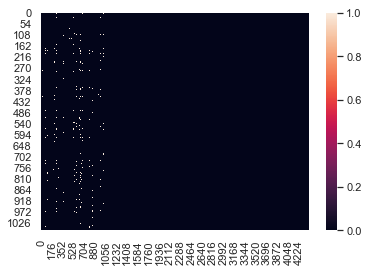

In [4]:
# DATA DESCRITION
# 1064 knockouts
# 4388 nodes in graph (reactions + metabolites) 310 metabolites have values the others not
# X 1. reaction knock out 2. wildtype flux 3. ??
# a hat = first dimension of adjacency
# adjacency dimensions 1. stochimoetric 2?. correlation of reactions 3?. regulatory network

loaded = np.load("../Data/NN_e_coli_data.npz")
data = dict(zip(loaded["arr_1"], loaded["arr_0"]))
for x in list(data.keys()):
    print(x, " : ", data[x].shape)
ax = sns.heatmap(data["Y"][:,:,0])

# ABOUT THE HEATMAP
# The left part are the measured metabolites (white dots)
# To the right of that are other unmeasured metabolites (black dots) & then reactions (black dots)
# So for Y you should only compute loss for MEASURED METABOLITES (and discard unmeasured metab. & reactions)

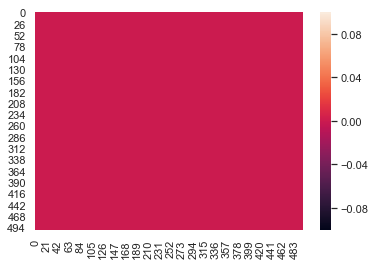

In [5]:
ax = sns.heatmap(data["adjacency"][:500,:500,1])

In [53]:
df = pd.read_table("../Data/Genome-wide/Metabolite_z_values_with_reactions.tsv", index_col=0)

In [59]:
df.describe()

,1pyr5c,23camp,23ccmp,23cgmp,23cump,23dhb,23dhmb,23dhmp,23doguln,26dap_LL,...,ura,uri,val__L,xan,xmp,xu5p__D,xu5p__L,xyl__D,xylu__D,xylu__L
count,3807.000000,3807.00000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,...,3807.00000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000,3807.000000
mean,-0.030876,0.07102,0.152778,0.071549,0.130555,0.085371,0.105003,0.086112,0.061525,0.047825,...,-0.04640,-0.014096,0.060301,0.041367,-0.030893,0.050002,0.050002,0.060071,0.060071,0.060071
std,1.000001,1.00000,0.999999,1.000001,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000001,1.000001,1.000001
min,-5.865300,-3.04390,-2.516500,-3.239000,-2.583700,-2.021300,-2.262500,-5.498000,-0.883100,-2.894500,...,-5.53000,-4.276200,-4.009800,-4.165300,-4.191400,-3.722100,-3.722100,-3.716800,-3.716800,-3.716800
25%,-0.507850,-0.53590,-0.393450,-0.524450,-0.426200,-0.261500,-0.314600,-0.472500,-0.062350,-0.447250,...,-0.47650,-0.411900,-0.585850,-0.486200,-0.586550,-0.390500,-0.390500,-0.570100,-0.570100,-0.570100
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.518600,0.56315,0.482300,0.539700,0.509600,0.326850,0.342350,0.478800,0.069550,0.457900,...,0.46585,0.437150,0.641600,0.520800,0.529400,0.465450,0.465450,0.621450,0.621450,0.621450
max,6.925000,6.52340,7.069100,10.728200,6.417300,41.244900,39.559700,10.093400,35.244600,28.725000,...,6.92150,20.363500,7.325200,17.428200,8.838100,31.584700,31.584700,8.257400,8.257400,8.257400


In [60]:
df.apply(pd.DataFrame.describe, axis=1)

,count,unique,top,freq
aaeA,310.0,201.0,-0.2585,9.0
aaeB,310.0,200.0,-0.2109,9.0
aaeR,310.0,201.0,0.6520,9.0
aaeX,310.0,200.0,0.0867,9.0
aas,311.0,200.0,-0.3118,9.0
aat,310.0,200.0,-0.2631,9.0
abgA,310.0,200.0,-0.0582,9.0
abgB,310.0,198.0,-1.3123,9.0
abgR,310.0,201.0,-0.3153,9.0
abgT,310.0,199.0,0.5020,9.0


# Questions to Kristian

* Transforming the hypergraph to a bipartite graph creates two classes of nodes, doesn't that violate some GCN assumptions?
Maybe add directions instead of positive negative stochiometric values?
* Train multiple convolutional filters per layer?
* How did you decide about architecture (4 layers with concatenation + fc layer)?
* Reverse task predict gene knockouts from metabolite profiles?
* What threshold did you use for z-scores to label them 1 (change) 0 (no change)?
assume normally distributed compte pvalue and outer 5% tails is signigficant change
* Test performance of a regular NN vs GCN?
* Why adjacency matrix has three layers (stochiometric matrix / regulatory network and?)
* Files of data transformations / data prep?
* File with HPC commands
* Suggestions for leaving out metabolites / genes
* Suggestions for grouping metabolites / genens
Genes were classified according to the Cluster of Orthologous Groups. Annotated ions were grouped according to the genome-scale metabolic model of Escherichia coli (Orth
et al, 2011).